# Graduation Thesis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [5]:
np.random.seed(1258)

In [117]:
# shifts of mean and variances
x = []
y = []
for t in range(100):
    xt = np.random.normal(0, 1)
    yt = xt + np.random.normal(5, 0.5)
    x.append(xt)
    y.append(yt)
for t in range(100):
    xt = np.random.normal(0, 1)
    yt = xt + np.random.normal(1, 0.5)
    x.append(xt)
    y.append(yt)

for t in range(100):
    xt = np.random.normal(0, 1)
    yt = xt + np.random.normal(8, 1)
    x.append(xt)
    y.append(yt)

In [118]:
mean1 = [np.array(np.mean(np.array(x)[:100] - np.array(y)[:100])) for i in range(100)]
mean2 = [np.array(np.mean(np.array(x)[100:200] - np.array(y)[100:200])) for i in range(100)]
mean3 = [np.array(np.mean(np.array(x)[200:] - np.array(y)[200:])) for i in range(100)]

In [124]:
def res_mean(t):
    if t < 100:
        return mean1
    elif 100 <= t < 200:
        return mean2
    return mean3

In [129]:
t = np.arange(300)
resmean = [res_mean(t) for t in range(300)]

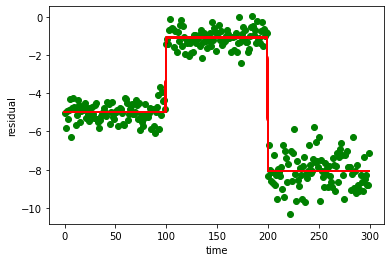

In [130]:
plt.plot(t, np.array(x) - np.array(y), 'bo', color='green')
plt.xlabel('time')
plt.ylabel('residual')
plt.plot(t, resmean, color='red')

In [153]:
# gradual shift of mean
x = []
y = []
t = 300
for i in range(t):
    xt = np.random.normal(0, 1)
    yt = xt + np.random.normal(np.log(t), np.log(t))
    x.append(xt)
    y.append(yt)

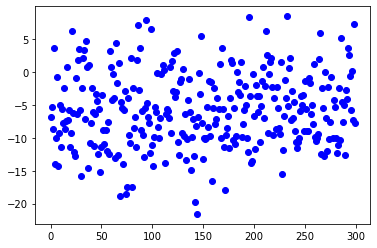

In [154]:
plt.plot(np.arange(t), np.array(x) - np.array(y), 'bo')

In [156]:
# generate data (change point mode), user needs to configure structural equations

# x1->x2->y

# two change points
n = 300
t1 = 100
t2 = 200
x1 = []
x2 = []
y = []
for t in range(t1):
    xt1 = np.random.normal(0, 1)
    xt2 = 2 * xt1 + np.random.normal(0, 1)
    y.append(3 * xt2 + np.random.normal(0, 1))
    x1.append(xt1)
    x2.append(xt2)
for t in range(t1, t2): # intervene on x1
    x1.append(2)
    xt2 = 2 * xt1 + np.random.normal(0, 1)
    y.append(3 * xt2 + np.random.normal(0, 1))
    x2.append(xt2)
for t in range(t2, n): #intervene on x2
    x1.append(np.random.normal(0, 1))
    xt2 = np.random.normal(0, 1)
    y.append(3 * xt2 + np.random.normal(0, 1))
    x2.append(xt2)

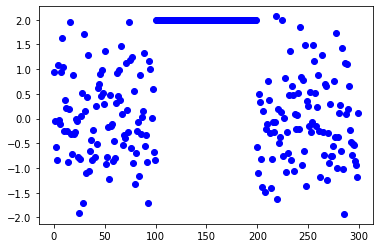

In [157]:
plt.plot(np.arange(n), x1, 'bo')

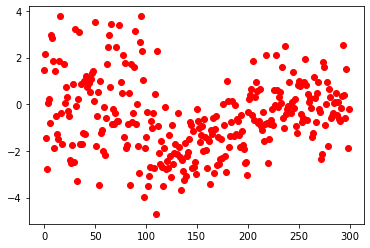

In [158]:
plt.plot(np.arange(n), x2, 'bo', color='red')

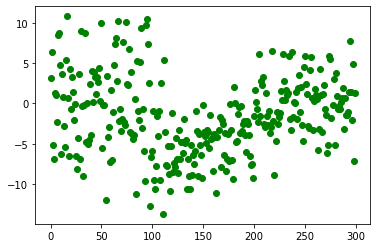

In [160]:
plt.plot(np.arange(n), y, 'bo', color='green')

In [167]:
d1 = np.array([y, x1, x2])
d1.shape

(3, 300)

In [400]:
epsilon = 1e-6

In [390]:
def multi_norm(x, mu, sigma):
    epsilon = 1e-6
    x = np.array(x)
#     print(np.transpose(x - mu)@linalg.inv(sigma)@(x - mu))
    return(((linalg.det(2 * np.pi * sigma) + epsilon)**(-0.5)) * np.exp(-0.5 * np.transpose(x - mu)@linalg.inv(sigma)@(x - mu)))

In [395]:
def multi_normal_density(x,mean,variance):
    return -len(x)/2*np.log(2*np.pi)-np.log(np.linalg.det(variance)+epsilon)/2-1/2*((x-mean)@np.linalg.inv(variance+np.diag([epsilon]*variance.shape[0]))@(x-mean))

In [396]:
def single_normal_density(x,mean,variance):
    return -1/2*np.log(2*np.pi*variance+epsilon)-1/2/(variance+epsilon)*(x-mean)*(x-mean)

In [391]:
def sing_norm(x, mu, sigma):
    epsilon = 1e-6
#     print(float(sigma)**(-1))
    return(((2 * np.pi * sigma + epsilon)**(-0.5)) * np.exp(-0.5 * float(sigma)**(-1) * (x - mu)**2))

In [416]:
# HG
# data[array]: [y, x1, ..., xp]
# y[array]: y[t] is scalar
# xi[array]: xi[t] is scalar
# pi[array]: pi[k] is scalar
# a[array]: a[k][i] is scalar
# sigma[array]: sigma[k][i][j] is scalar
# ssquare[array]: ssquare[k] is scalar
# b[array]: b[k][d] is scalar
# regu[scalar]: the regularizer(lambda)
# simutime[scalar]: epoches
# K[scalar]: optional number of environments
def HG(data, simutime, K, regu=10):
    n = len(data[0]) # number of observations
    num = len(data) # number of predictors plus one
    prob = [[0 for i in range(K)] for t in range(n)] # prob[array]: prob[t][k] is scalar
    pi = np.array([1 / K for k in range(K)])
    a = np.array([[1 for d in range(num - 1)] for k in range(K)])
    sigma = np.array([np.diag([1 for i in range(num - 1)]) for k in range(K)])
    ssquare = np.array([1 for k in range(K)])
    b = np.array([[1 for d in range(num - 1)] for k in range(K)])
    slope = (0.05 - regu) / simutime # regularizer decreases linearly
    x = data[1:]
    y = data[0]
    for time in range(simutime):
        print('%d th simulation' % time)
        print('pi', pi)
        # update prob -- soft clustering
        for t in range(n):
            element = [] # store summation terms
            for k in range(K):
                element.append((pi[k] * np.exp(multi_normal_density(x[:, t], a[k], sigma[k])) * \
                               np.exp(single_normal_density(y[t], np.transpose(x[:, t])@b[k], ssquare[k])))**(1 / regu))
            denomi = np.sum(element)
            for k in range(K):
                prob[t][k] = element[k] / (denomi + epsilon)
#         print(prob)
        # update pi
        for k in range(K):
            pi[k] = np.sum(prob, axis=0)[k] / n
        # update a
        for k in range(K):
            numer = 0
            for t in range(n):
                numer += prob[t][k] * x[:, t]
            a[k] = numer / np.sum(prob, axis=0)[k]
        # update sigma
        for k in range(K):
            numer = 0 # store the numerator in eq.(5.6)
            for t in range(n):
                numer += prob[t][k] * (x[:, t] - a[k])@np.transpose((x[:, t] - a[k]))
            sigma[k] = numer / np.sum(prob, axis=0)[k]
        # update b
        for k in range(K):
            left = 0 # store the left part of eq.(5.8)
            right = 0 # store the right part of eq.(5.8)
            for t in range(n):
                left += prob[t][k] * np.outer(x[:, t], x[:, t].T)
                right += prob[t][k] * y[t] * x[:, t]
            b[k] = linalg.inv(left)@right
        # update ssquare
        for k in range(K):
            numer = 0 # store the numerator of eq.(5.7)
            for t in range(n):
                numer += prob[t][k] * (y[t] - np.transpose(x[:, t])@b[k])**2
            ssquare[k] = numer / np.sum(prob, axis=0)[k]
        # update lambda 
        regu += slope
        

In [417]:
np.array(np.transpose([1, 2, 3]))@np.array([1, 2, 3])

14

In [418]:
HG(d1, 20, 3)

0 th simulation
pi [0.33333333 0.33333333 0.33333333]
1 th simulation
pi [0.3333304 0.3333304 0.3333304]
2 th simulation
pi [0.00218242 0.00218242 0.00218242]


<ipython-input-416-c04657d1d3c6>:46: RuntimeWarning: invalid value encountered in true_divide
  a[k] = numer / np.sum(prob, axis=0)[k]
<ipython-input-416-c04657d1d3c6>:52: RuntimeWarning: invalid value encountered in double_scalars
  sigma[k] = numer / np.sum(prob, axis=0)[k]


ValueError: cannot convert float NaN to integer

In [326]:
np.sum?

In [176]:
linalg.det?

In [252]:
4**(-1)

0.25

In [261]:
1**(-1)

1.0

In [350]:
d1[1:][:, 200]

array([-0.5783304 , -0.33447339])

In [362]:
np.diag?

In [419]:
plt.plot?

In [420]:
np.matrix?

In [421]:
np.matrix([1, 2, 3, 4])

matrix([[1, 2, 3, 4]])

In [422]:
a = np.array([1, 2, 3, 4])

In [423]:
a.reshape(2, 2)

array([[1, 2],
       [3, 4]])

In [424]:
a

array([1, 2, 3, 4])